In [1]:
%load_ext lab_black

In [233]:
import numpy as np
import pandas as pd

import re
from collections import Counter

import yake

from tqdm.auto import tqdm
from nltk import pos_tag
import nltk

import seaborn as sns
import matplotlib.pyplot as plt

from nltk.tokenize import sent_tokenize
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn import metrics
import hdbscan

In [172]:
data = pd.read_csv("../data/sentences.csv")
data.head()

,text,text_original,pii
0,natural gas production use increase unite stat...,Natural gas production and use has increased i...,S2666765721000478
1,natural gas extract conventional unconventiona...,Natural gas is extracted through conventional ...,S2666765721000478
2,extract natural gas transport production site ...,"Once extracted, natural gas is transported fro...",S2666765721000478
3,compressor station also refer pump station loc...,"Compressor stations, also referred to as pumpi...",S2666765721000478
4,depend specific factor diameter pipeline topog...,"Depending on specific factors, such as the dia...",S2666765721000478


In [188]:
articles = pd.read_csv("../data/health_ng.csv")
articles.index = articles["pii"]
articles.head()

,pii,title,date,text
pii,,,,
S2666765721000478,S2666765721000478,Survey of Airborne Organic Compounds in Reside...,2021-06-13T00:00:00.000Z,Natural gas production and use has increased i...
S0269749119376717,S0269749119376717,Natural gas leaks and tree death: A first-look...,2020-04-03T00:00:00.000Z,"Urban vegetation, in particular tree canopy, i..."
S2352484721000202,S2352484721000202,Experimental optimization of engine performanc...,2021-01-21T00:00:00.000Z,All data required for reproducing this researc...
S2213138820300308,S2213138820300308,Environmental life cycle assessment of glyceri...,2020-10-09T00:00:00.000Z,Glycerine is the usual commercial name in the ...
S2352484720312312,S2352484720312312,Comparative cost assessment of sustainable ene...,2020-07-23T00:00:00.000Z,The energy of natural gas can be transported i...


In [174]:
with open("../data/vectors_reduced.npy", "rb") as f:
    vectors = np.load(f)

In [175]:
data["x"] = vectors[:, 0]
data["y"] = vectors[:, 1]

In [189]:
articles = articles.join(data.groupby("pii")[["x", "y"]].mean())
articles.head()

,pii,title,date,text,x,y
pii,,,,,,
S0001457513001735,S0001457513001735,Development and validation of safety climate s...,2013-05-10T00:00:00.000Z,Safety climate is defined as the shared percep...,-2.941993,-2.226599
S0001706X16301231,S0001706X16301231,Dispersal of <ce:italic>Lutzomyia longipalpis<...,2016-09-15T00:00:00.000Z,Visceral leishmaniasis (VL) is a globally tran...,-2.421822,-5.398034
S0006320716309752,S0006320716309752,Spatial modelling of non-target exposure to an...,2017-06-16T00:00:00.000Z,"Alberta, Canada, is rich in natural resources,...",-2.414597,0.837719
S0006497120449031,S0006497120449031,From an old remedy to a magic bullet: molecula...,2020-12-14T00:00:00.000Z,Arsenic is the 20th most abundant element in t...,-2.729861,4.537601
S0007091217300508,S0007091217300508,Financial and environmental costs of reusable ...,2017-12-13T00:00:00.000Z,Editor's key points•Anaesthetists use large am...,0.133853,0.703562


In [190]:
articles = articles.join(
    data.groupby("pii")["text"].agg(" ".join), rsuffix="_processed"
)
articles.head()

,pii,title,date,text,x,y,text_processed
pii,,,,,,,
S0001457513001735,S0001457513001735,Development and validation of safety climate s...,2013-05-10T00:00:00.000Z,Safety climate is defined as the shared percep...,-2.941993,-2.226599,safety climate define share perception among w...
S0001706X16301231,S0001706X16301231,Dispersal of <ce:italic>Lutzomyia longipalpis<...,2016-09-15T00:00:00.000Z,Visceral leishmaniasis (VL) is a globally tran...,-2.421822,-5.398034,visceral leishmaniasis globally transmit paras...
S0006320716309752,S0006320716309752,Spatial modelling of non-target exposure to an...,2017-06-16T00:00:00.000Z,"Alberta, Canada, is rich in natural resources,...",-2.414597,0.837719,alberta canada rich natural resources find pri...
S0006497120449031,S0006497120449031,From an old remedy to a magic bullet: molecula...,2020-12-14T00:00:00.000Z,Arsenic is the 20th most abundant element in t...,-2.729861,4.537601,arsenic abundant element earth chemical analog...
S0007091217300508,S0007091217300508,Financial and environmental costs of reusable ...,2017-12-13T00:00:00.000Z,Editor's key points•Anaesthetists use large am...,0.133853,0.703562,editors key point anaesthetists use large amou...


In [193]:
articles = articles.dropna()

In [194]:
article_vector = articles[["x", "y"]].values

In [211]:
%%time
clusterer = hdbscan.HDBSCAN(min_cluster_size=50, min_samples=1, cluster_selection_epsilon=1)
clusterer = SpectralClustering()
cluster_labels = clusterer.fit_predict(article_vector)
articles["label"] = cluster_labels
articles["label"].max()

Wall time: 1.16 s


<timed exec>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7

C:\Programs\miniconda3\envs\gaz\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

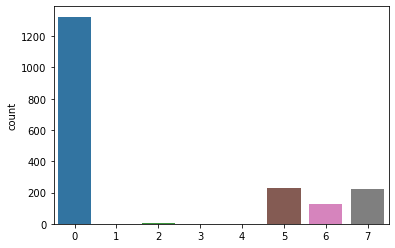

In [212]:
sns.countplot(cluster_labels)

In [154]:
articles["label"] = cluster_labels

In [155]:
articles.to_csv("../data/articles_labeled.csv", index=False)

(-8.5, 9.5)

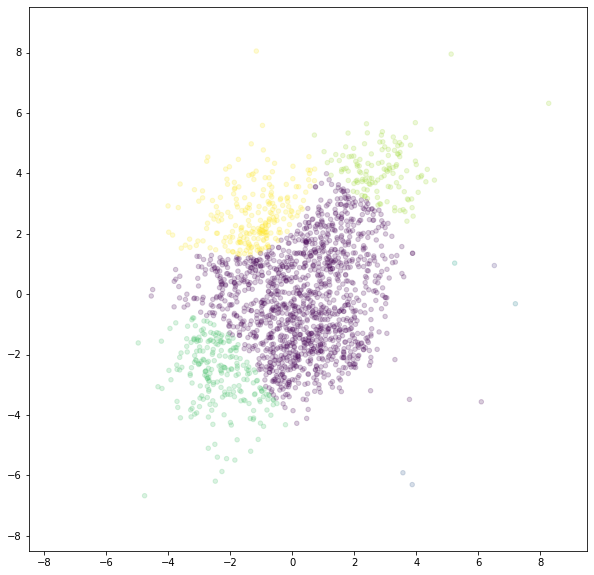

In [213]:
fig = plt.figure(figsize=(10, 10))

plt.scatter(
    article_vector[:, 0], article_vector[:, 1], s=20, alpha=0.2, c=cluster_labels
)
plt.xlim(-8.5, 9.5)
plt.ylim(-8.5, 9.5)

In [31]:
data = pd.read_csv("../data/sentences_labeled.csv")
data.head()

,text,text_original,pii,label
0,natural gas production use increase unite stat...,Natural gas production and use has increased i...,S2666765721000478,6
1,natural gas extract conventional unconventiona...,Natural gas is extracted through conventional ...,S2666765721000478,3
2,extract natural gas transport production site ...,"Once extracted, natural gas is transported fro...",S2666765721000478,6
3,compressor station also refer pump station loc...,"Compressor stations, also referred to as pumpi...",S2666765721000478,1
4,depend specific factor diameter pipeline topog...,"Depending on specific factors, such as the dia...",S2666765721000478,1


In [326]:
from more_itertools import windowed
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob


def extract_keywords(text, top_n=20):
    ke = yake.KeywordExtractor(n=5, top=50)
    keywords = ke.extract_keywords(text)
    return keywords


def window_phrases(phrases, window_size=3):
    #     phrases = windowed(text.split(), window_size)
    #     phrases = sent_tokenize(text)
    phrases = [
        i for i in tqdm(phrases) if "health" in i.lower() and "natural gas" in i.lower()
    ]
    polarities = np.array([nlp(phrases)._.polarity for phrases in tqdm(phrases)])
    #     c = Counter(phrases)
    return phrases, polarities

In [287]:
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe("spacytextblob")

In [327]:
phrases, polarities = window_phrases(data["text_original"].values, window_size=2)

  0%|          | 0/498915 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

In [328]:
polarities

array([ 0.04285714,  0.095     ,  0.05      ,  0.184375  ,  0.085     ,
        0.1       ,  0.09444444,  0.075     ,  0.13333333, -0.1452381 ,
       -0.07      ,  0.0375    ,  0.03333333,  0.040625  ,  0.05      ,
        0.05      ,  0.27333333, -0.02952381, -0.03928571,  0.08571429,
        0.03137255,  0.00185185,  0.04388889,  0.15833333,  0.1       ,
       -0.3       , -0.3       , -0.06875   , -0.3       , -0.01272727,
       -0.025     ,  0.11818182,  0.1       ,  0.042     ,  0.040625  ,
        0.20243056,  0.05      ,  0.02916667, -0.02222222,  0.04535714,
        0.12232143,  0.16428571,  0.225     ,  0.11875   , -0.09772727,
        0.04444444,  0.05      ,  0.15      ,  0.14444444, -0.04375   ,
        0.03333333,  0.14814815,  0.225     ,  0.1       , -0.00833333,
        0.1829932 ,  0.06      , -0.06388889,  0.11666667,  0.025     ,
        0.11875   ,  0.23333333,  0.05      ,  0.23956044,  0.11875   ,
       -0.00333333,  0.18214286,  0.03333333,  0.1       ,  0.00

In [324]:
[phrases[i] for i in range(len(polarities)) 5]

['However, there is limited information about exposure to air contaminants and resulting health effects in residents living near natural gas compressor stations.',
 'Due to the rapid rise of natural gas and fracking technology coupled with the lack of transparency involved in the processes, many questions surround the potential public health impacts (Adgate et al., 2014, Fisher et al., 2018).',
 'In an effort to contribute to understanding of tree health in proximity to gas leaks, we conducted a formal assessment of tree death and fugitive natural gas exposure in a densely populated urban community in Massachusetts, USA.',
 'While not all trees removed each year are due to methane exposure-related decline, our results indicate that fugitive natural gas could be an important contributor to urban tree death and that these deaths could have notable ecological, human health, and economic impacts.',
 'We found that exposure to elevated soil methane concentrations was associated with signifi

In [224]:
keywords = {}
for i in tqdm(articles["label"].unique()):
    docs = articles[articles["label"] == i]["text_processed"].values
    try:
        top_words = extract_keywords(" ".join(docs), top_n=50)
        print("health" in top_words, i)
        keywords[i] = top_words
    except:
        print(i)

  0%|          | 0/8 [00:00<?, ?it/s]

False 5
0


KeyboardInterrupt: 

In [220]:
%%time
ke = yake.KeywordExtractor(n=2, top=50)
keywords = ke.extract_keywords(' '.join(articles[articles["label"] == i]["text"].values))

Wall time: 520 ms


In [221]:
keywords

[('wing phenotype', 0.0007688147195421912),
 ('Figure', 0.0022015695631456486),
 ('uex', 0.0023547040022274305),
 ('held-up wing', 0.002862492591257683),
 ('wing', 0.00300532570535276),
 ('phenotype', 0.0032568436281381922),
 ('mutant flies', 0.0036460704038701955),
 ('flies', 0.005944899042620344),
 ('Figures', 0.006761963658233063),
 ('mutant', 0.007531316168501753),
 ('Uex expression', 0.007887999557205832),
 ('Drosophila', 0.008488442596446448),
 ('Uex protein', 0.00915746765041203),
 ('wing held-up', 0.010495806167944837),
 ('held-up', 0.011143578821059862),
 ('mutants', 0.011834925407645611),
 ('nervous system', 0.011863574452323897),
 ('expression', 0.01505181624992486),
 ('held-up phenotype', 0.017452512851913238),
 ('neurons', 0.019701282014815285),
 ('nervous', 0.021949160192833026),
 ('system', 0.023214715730864435),
 ('Uex levels', 0.024453084708545902),
 ('uex phenotype', 0.02485170106823377),
 ('PRL', 0.029099614506787466),
 ('exposure', 0.029534589575830588),
 ('phenotyp

In [25]:
8328 / len(docs)

0.07362158434922515

In [31]:
top_words = extract_keywords(' '.join(docs), top_n=10)
top_words = pd.DataFrame(top_words, columns=("word", "count"))
top_words.head()

,word,count
0,patients,30010
1,cancer,13482
2,lung,13012
3,study,10315
4,use,10090


<AxesSubplot:xlabel='word', ylabel='count'>

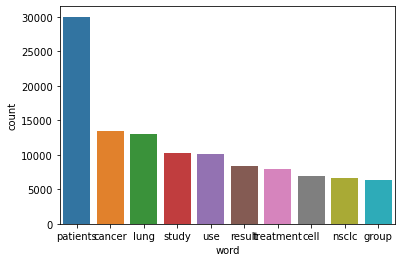

In [33]:
sns.barplot(data=top_words, x='word', y='count')